# Preamble

In [1]:
from imports import *

In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
PATH_TO_RAW_DATA = 'challenge_data/drug_synergy_data/raw_data/Raw_Data_csv'

In [4]:
ls challenge_data

challenge_data.h5  drug_synergy_data/  sanger_molecular_data/


In [5]:
print(store)

<class 'pandas.io.pytables.HDFStore'>
File path: challenge_data/challenge_data.h5
/ch1_leaderboard_monotherapy                      frame        (shape->[591,14]) 
/ch1_test_monotherapy                             frame        (shape->[1089,14])
/ch1_train_combination_and_monotherapy            frame        (shape->[2156,14])
/ch2_leaderboard_monotherapy                      frame        (shape->[3870,14])
/ch2_test_monotherapy                             frame        (shape->[3827,14])
/drug_info_release                                frame        (shape->[119,8])  


# Load data

In [6]:
def get_data(cell_line, combination_id, rep, subfolder):
    """
    subfolder : {'ch1_training_combinations', 'ch1_ch2_monoTherapy'}
    """
    def get_filename(rep):
        return op.join(PATH_TO_RAW_DATA, subfolder, '{}.{}.{}.csv'.format(combination_id, cell_line, rep))
    
    if op.isfile(get_filename(rep)):
        data = pd.read_csv(get_filename(rep), sep=',', index_col=0)
        agent_1 = data.loc['Agent1']['0']
        agent_2 = data.loc['Agent2']['0']
        unit_1 = data.loc['Unit1']['0']
        unit_2 = data.loc['Unit2']['0']
        title = data.loc['Title']['0']
        data_grid = data.iloc[:6,:6].astype(float)
        data_grid_max = data_grid.iloc[0,0]
        data_grid = data_grid / data_grid_max * 100
        monotherapy_1_x = data_grid.index.astype(float).values
        monotherapy_1_y = data_grid['0'].astype(float).values
        monotherapy_2_x = data_grid.columns.astype(float).values
        monotherapy_2_y = data_grid.loc['0'].astype(float).values
        return (
            cell_line, combination_id, rep,
            data_grid, data_grid_max, agent_1, agent_2, unit_1, unit_2, title, 
            monotherapy_1_x, monotherapy_1_y, monotherapy_2_x, monotherapy_2_y, 
        )
    return None

In [7]:
data = {}
dfs_to_analyze = [
    ('ch1_train_combination_and_monotherapy', 'ch1_training_combinations'),
    ('ch1_leaderboard_monotherapy', 'ch1_ch2_monoTherapy'),
    ('ch1_test_monotherapy', 'ch1_ch2_monoTherapy'),
    ('ch2_leaderboard_monotherapy', 'ch1_ch2_monoTherapy'),
    ('ch2_test_monotherapy', 'ch1_ch2_monoTherapy')
]


for df_name, subfolder in dfs_to_analyze:
    new_list = []
    for rep in ['Rep1', 'Rep2', 'Rep3']:
        new_list.extend([
            get_data(cell_line, combination_id, rep, subfolder)
            for (combination_id, cell_line)
            in store.get(df_name)[['COMBINATION_ID', 'CELL_LINE']].drop_duplicates().values
        ])

    new_list_nonulls = [row for row in new_list if row]

    columns = [
        'CELL_LINE', 'COMBINATION_ID', 'REP', 
        'DATA', 'DATA_MAX', 'AGENT_A', 'AGENT_B', 'UNIT_A', 'UNIT_B', 'TITLE',
        'MONOTHERAPY_A_X', 'MONOTHERAPY_A_Y', 'MONOTHERAPY_B_X', 'MONOTHERAPY_B_Y', 
    ]
    store[df_name + '_data'] = pd.DataFrame(
        data=new_list_nonulls,
        columns=columns,
    )

/home/kimlab1/strokach/anaconda3/lib/python3.4/site-packages/pandas/io/pytables.py:2577: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['CELL_LINE', 'COMBINATION_ID', 'REP', 'DATA', 'AGENT_A', 'AGENT_B', 'UNIT_A', 'UNIT_B', 'TITLE', 'MONOTHERAPY_A_X', 'MONOTHERAPY_A_Y', 'MONOTHERAPY_B_X', 'MONOTHERAPY_B_Y']]

  warnings.warn(ws, PerformanceWarning)


In [8]:
store['ch1_train_combination_and_monotherapy_data'].head(4)

,CELL_LINE,COMBINATION_ID,REP,DATA,DATA_MAX,AGENT_A,AGENT_B,UNIT_A,UNIT_B,TITLE,MONOTHERAPY_A_X,MONOTHERAPY_A_Y,MONOTHERAPY_B_X,MONOTHERAPY_B_Y
0,BT-20,ADAM17.AKT,Rep1,0 0.75 2.5 ...,16803.5,ADAM17,AKT,\muM,\muM,BT-20,"[0.0, 0.01, 0.03, 0.1, 0.3, 1.0]","[100.0, 96.4888267325, 97.6284702592, 95.58722...","[0.0, 0.75, 2.5, 7.5, 25.0, 75.0]","[100.0, 97.8040289225, 99.7232719374, 94.69753..."
1,CAL-51,ADAM17.AKT,Rep1,0 0.75 2.5 ...,16752.0,ADAM17,AKT,\muM,\muM,CAL-51,"[0.0, 0.01, 0.03, 0.1, 0.3, 1.0]","[100.0, 92.8217526266, 94.0126552053, 89.28784...","[0.0, 0.75, 2.5, 7.5, 25.0, 75.0]","[100.0, 96.075095511, 94.2514326648, 95.233404..."
2,HCC1187,ADAM17.AKT,Rep1,0 0.75 2.5 ...,16751.0,ADAM17,AKT,\muM,\muM,HCC1187,"[0.0, 0.01, 0.03, 0.1, 0.3, 1.0]","[100.0, 108.298012059, 97.5732792072, 94.30780...","[0.0, 0.75, 2.5, 7.5, 25.0, 75.0]","[100.0, 103.796788251, 109.041251269, 104.4833..."
3,HCC1806,ADAM17.AKT,Rep1,0 0.75 2.5 ...,20381.5,ADAM17,AKT,\muM,\muM,HCC1806,"[0.0, 0.01, 0.03, 0.1, 0.3, 1.0]","[100.0, 104.332360229, 98.3931506513, 103.4663...","[0.0, 0.75, 2.5, 7.5, 25.0, 75.0]","[100.0, 91.5315359517, 88.833010328, 86.046169..."


In [9]:
store['ch1_train_combination_and_monotherapy_data'].loc[0, 'DATA']

,0,0.75,2.5,7.5,25,75
0,100.000000,97.804029,99.723272,94.697533,95.009968,92.938971
0.01,96.488827,89.838427,97.729640,92.433124,88.377421,87.353825
0.03,97.628470,88.758294,94.405927,90.076472,86.931294,88.746392
0.1,95.587229,84.166989,86.330229,87.859672,84.910882,80.182700
0.3,88.776148,80.233285,84.050942,81.851995,77.787366,76.469188
1,79.382272,64.424078,69.396257,69.741423,66.997947,69.440890


# From "explore_provided_data.ipynb"

In [ ]:
# Plot correlation between monotherapy features (SAME CELL_LINE AND MAX_CONC!)
df1a = (
    ch1_train_combination_and_monotherapy
    [ch1_train_combination_and_monotherapy['QA'] == 1]
    [['CELL_LINE', 'COMPOUND_A', 'MAX_CONC_A', 'IC50_A', 'H_A', 'Einf_A']]
    .rename(columns={
        'CELL_LINE': 'cell_line',
        'COMPOUND_A': 'compound',
        'MAX_CONC_A': 'max_conc',
        'IC50_A': 'ic50',
        'H_A': 'h',
        'Einf_A': 'e_inf'
    })
)

df1b = (
    ch1_train_combination_and_monotherapy
    [ch1_train_combination_and_monotherapy['QA'] == 1]
    [['CELL_LINE', 'COMPOUND_B', 'MAX_CONC_B', 'IC50_B', 'H_B', 'Einf_B']]
    .rename(columns={
        'CELL_LINE': 'cell_line',
        'COMPOUND_B': 'compound',
        'MAX_CONC_B': 'max_conc',
        'IC50_B': 'ic50',
        'H_B': 'h',
        'Einf_B': 'e_inf'
    })
)

df1 = pd.concat([df1a, df1b], ignore_index=True).reset_index()
display(HTML('<b>df1</b>'))
display(df1.head())

df = df1.merge(df1.copy(), on=['cell_line', 'compound', 'max_conc'], how='outer', suffixes=('_1', '_2'))
df = df[df['index_1'] != df['index_2']]

display(HTML('<b>df</b>'))
display(df[['ic50_1', 'h_1', 'e_inf_1', 'ic50_2', 'h_2', 'e_inf_2']].corr())

fg, ax = plt.subplots(1,3,figsize=(14,4))
df.plot(x='ic50_1', y='ic50_2', kind='scatter', alpha=0.6, loglog=True, ax=ax[0])
df.plot(x='h_1', y='h_2', kind='scatter', alpha=0.6, ax=ax[1])
df.plot(x='e_inf_1', y='e_inf_2', kind='scatter', alpha=0.6, ax=ax[2])

In [ ]:
# Plot correlation between monotherapy features
df1a = (
    ch1_train_combination_and_monotherapy
    [ch1_train_combination_and_monotherapy['QA'] == 1]
    [['COMPOUND_A', 'IC50_A', 'H_A', 'Einf_A']]
    .rename(columns={
        'COMPOUND_A': 'compound',
        'IC50_A': 'ic50',
        'H_A': 'h',
        'Einf_A': 'e_inf'
    })
)

df1b = (
    ch1_train_combination_and_monotherapy
    [ch1_train_combination_and_monotherapy['QA'] == 1]
    [['COMPOUND_B', 'IC50_B', 'H_B', 'Einf_B']]
    .rename(columns={
        'COMPOUND_B': 'compound',
        'IC50_B': 'ic50',
        'H_B': 'h',
        'Einf_B': 'e_inf'
    })
)

df1 = pd.concat([df1a, df1b], ignore_index=True).reset_index()
display(HTML('<b>df1</b>'))
display(df1.head())

df = df1.merge(df1.copy(), on=['compound'], how='outer', suffixes=('_1', '_2'))
df = df[df['index_1'] != df['index_2']]

display(HTML('<b>df</b>'))
display(df[['ic50_1', 'h_1', 'e_inf_1', 'ic50_2', 'h_2', 'e_inf_2']].corr())

fg, ax = plt.subplots(1,3,figsize=(14,4))
df.plot(x='ic50_1', y='ic50_2', kind='scatter', alpha=0.2, loglog=True, ax=ax[0])
df.plot(x='h_1', y='h_2', kind='scatter', alpha=0.2, ax=ax[1])
df.plot(x='e_inf_1', y='e_inf_2', kind='scatter', alpha=0.2, ax=ax[2])

In [ ]:
# Correlation between synergy scores
df1 = (
    ch1_train_combination_and_monotherapy
    [ch1_train_combination_and_monotherapy['QA'] == 1]
    [['COMBINATION_ID', 'SYNERGY_SCORE']]
    .reset_index()
)

df = df1.merge(df1.copy(), on='COMBINATION_ID', suffixes=('_1', '_2'))
df = df[df['index_1'] != df['index_2']]

display(df.head())

display(df[['SYNERGY_SCORE_1', 'SYNERGY_SCORE_2']].corr())

df.plot(x='SYNERGY_SCORE_1', y='SYNERGY_SCORE_2', kind='scatter')
plt.show()

In [176]:
from graph_tool.all import *

[autoreload of numpy.matrixlib failed: Traceback (most recent call last):
  File "/home/kimlab1/strokach/anaconda3/lib/python3.4/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
NameError: name 'defmatrix' is not defined
]
[autoreload of numpy.core failed: Traceback (most recent call last):
  File "/home/kimlab1/strokach/anaconda3/lib/python3.4/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'multiarray'
]
[autoreload of numpy.lib failed: Traceback (most recent call last):
  File "/home/kimlab1/strokach/anaconda3/lib/python3.4/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'scimath'
]
[autoreload of numpy.testing failed: Traceback (most recent call last):
  File "/home/kimlab1/strokach/anaconda3/lib/python3.4/site-packages/IPython/

RepositoryError: Typelib file for namespace 'Pango', version '1.0' not found

# Fit data

In [168]:
##
def hill(p, x):
    ic_50, h, e_inf = p
    return 100 + ((e_inf - 100) / (1 + (ic_50 / x) ** h))


def hill_log(p, x):
    ic_50_log, h, e_inf = p
    return 100 + (e_inf - 100) / (1 + 10 ** ((ic_50_log - np.log10(x)) * h))


def error_fn(p, x, y):
    return np.sqrt( np.sum( (y - hill_log(p, x))**2 ) )


def _get_p0_ec50(x, y):
    x_i_last = -4
    for x_i, y_i in zip(x[1:], y[1:]):
        if y_i < 50:
            return (x_i_last + x_i) / 2
        x_i_last = x_i
    return x_i

#assert _get_p0_ec50([0,1,2], [100,60,30]) == 1.5
#assert _get_p0_ec50([0,1,2], [100,90,80]) == 2
#assert _get_p0_ec50([0,1,2], [100,20,10]) == 0.5


def fit_hill(row):
    ic50, h, e_inf, x, y = row
    p0_bounds = [(-6,3), (0.1,10), (0,100)]
    
    plsq = []
    
    p0 = np.array([ic50, h, e_inf])
    p0[0] = np.log10(p0[0])
    #p0[0] = _get_p0_ec50(np.log10(x), y)
    p0[1] = min([p0[1], p0_bounds[1][1]])
    #p0[2] = min(y)
    plsq += [sp.optimize.minimize(
        error_fn, p0, args=(x, y), method='L-BFGS-B', bounds=p0_bounds)]
    
    plsq = sorted(plsq, key=lambda x: x.fun)[0]
    message = plsq.message.decode() if isinstance(plsq.message, bytes) else plsq.message
    p_out = list(plsq.x)
    p_out[0] = 10 ** p_out[0]
    return p_out + [plsq.fun, message, plsq.success]

In [169]:
if False:
    p0 = np.array([ic50, h, e_inf])
    p0[0] = np.log10(p0[0])
    plsq += [sp.optimize.minimize(
        error_fn, p0, args=(x, y), method='L-BFGS-B', bounds=p0_bounds)]    
    
    p0[0] = _get_p0_ec50(np.log10(x), y)
    plsq += [sp.optimize.minimize(
        error_fn, p0, args=(x, y), method='L-BFGS-B', bounds=p0_bounds)]

    p0[1] = 1
    plsq += [sp.optimize.minimize(
        error_fn, p0, args=(x, y), method='L-BFGS-B', bounds=p0_bounds)]
    
    p0[2] = 0
    plsq += [sp.optimize.minimize(
        error_fn, p0, args=(x, y), method='L-BFGS-B', bounds=p0_bounds)]
    
    p0[0] = -2
    plsq += [sp.optimize.minimize(
        error_fn, p0, args=(x, y), method='L-BFGS-B', bounds=p0_bounds)]
    
    p0[0] = 0
    plsq += [sp.optimize.minimize(
        error_fn, p0, args=(x, y), method='L-BFGS-B', bounds=p0_bounds)]
    
    p0[0] = 2
    plsq += [sp.optimize.minimize(
        error_fn, p0, args=(x, y), method='L-BFGS-B', bounds=p0_bounds)]
    
    n_tries = 1
    while not plsq[-1].success and not plsq[-2].success and n_tries <= 5:
        p0 = [(x[0] + random.random() * (x[1] - x[0])) for x in p0_bounds]
        plsq += [sp.optimize.minimize(
            error_fn, p0, args=(x, y), method='L-BFGS-B', bounds=p0_bounds)]

In [170]:
df_ref = store['ch1_train_combination_and_monotherapy']
df_data = store['ch1_train_combination_and_monotherapy_data']

columns = [
    'CELL_LINE', 'COMBINATION_ID', 'QA',
    'IC50_A', 'H_A', 'Einf_A',
    'IC50_B', 'H_B', 'Einf_B',
]

df = df_data.merge(df_ref[columns], on=['CELL_LINE', 'COMBINATION_ID'], how='left')

(df['IC50_A_new'], df['H_A_new'], df['Einf_A_new'], 
 df['RMSE_A_new'], df['MESSAGE_A_new'], df['SUCCESS_A_new']) = list(zip(*
    df[['IC50_B', 'H_B', 'Einf_B', 'MONOTHERAPY_A_X', 'MONOTHERAPY_A_Y']]
    .apply(fit_hill, axis=1).values
))

(df['IC50_B_new'], df['H_B_new'], df['Einf_B_new'], 
 df['RMSE_B_new'], df['MESSAGE_B_new'], df['SUCCESS_B_new']) = list(zip(*
    df[['IC50_B', 'H_B', 'Einf_B', 'MONOTHERAPY_B_X', 'MONOTHERAPY_B_Y']]
    .apply(fit_hill, axis=1).values
))

In [171]:
dat.print2('Number of failed A:', len(df[~df['SUCCESS_A_new']]))
dat.print2('Number of null A:', df[['IC50_B_new', 'H_B_new', 'Einf_B_new']].isnull().any().sum())
dat.print2('Number of failed B:', len(df[~df['SUCCESS_B_new']]))
dat.print2('Number of null B:', df[['IC50_B_new', 'H_B_new', 'Einf_B_new']].isnull().any().sum())

dat.print2('Total number of rows:', len(df))
print()
dat.print2('RMSE mean A:', '{:,.0f}'.format(df['RMSE_A_new'].mean()))
dat.print2('RMSE mean B:', '{:,.0f}'.format(df['RMSE_B_new'].mean()))

Number of failed A:                                         0
Number of null A:                                           0
Number of failed B:                                         0
Number of null B:                                           0
Total number of rows:                                       2213

RMSE sum A:                                                 22
RMSE sum B:                                                 15


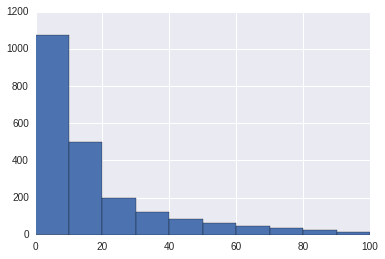

In [172]:
df['RMSE_A_new'].hist(range=(0, 100))

In [165]:
df.head(2)

,CELL_LINE,COMBINATION_ID,REP,DATA,DATA_MAX,AGENT_A,AGENT_B,UNIT_A,UNIT_B,TITLE,MONOTHERAPY_A_X,MONOTHERAPY_A_Y,MONOTHERAPY_B_X,MONOTHERAPY_B_Y,QA,IC50_A,H_A,Einf_A,IC50_B,H_B,Einf_B,IC50_A_new,H_A_new,Einf_A_new,RMSE_A_new,MESSAGE_A_new,SUCCESS_A_new,IC50_B_new,H_B_new,Einf_B_new,RMSE_B_new,MESSAGE_B_new,SUCCESS_B_new
0,BT-20,ADAM17.AKT,Rep1,0 0.75 2.5 ...,16803.5,ADAM17,AKT,\muM,\muM,BT-20,"[0.0, 0.01, 0.03, 0.1, 0.3, 1.0]","[100.0, 96.4888267325, 97.6284702592, 95.58722...","[0.0, 0.75, 2.5, 7.5, 25.0, 75.0]","[100.0, 97.8040289225, 99.7232719374, 94.69753...",1,1,0.809002,59.122436,9.639714,0.757977,91.593425,8.356430,0.635580,0,2.544460,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,True,9.053512,0.780355,91.779963,2.789367,CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL,True
1,CAL-51,ADAM17.AKT,Rep1,0 0.75 2.5 ...,16752.0,ADAM17,AKT,\muM,\muM,CAL-51,"[0.0, 0.01, 0.03, 0.1, 0.3, 1.0]","[100.0, 92.8217526266, 94.0126552053, 89.28784...","[0.0, 0.75, 2.5, 7.5, 25.0, 75.0]","[100.0, 96.075095511, 94.2514326648, 95.233404...",1,1,0.726984,11.150843,75.000000,0.375043,76.656479,1.372489,0.691105,0,5.680467,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,True,244.141098,0.338664,70.692922,2.902201,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,True


In [173]:
pd.set_option('display.max_columns', 50)

,index,CELL_LINE,AGENT,IC50,H,Einf,IC50_new,H_new,Einf_new
0,0,BT-20,ADAM17,1.000000,0.809002,59.122436,8.356430,0.635580,0.000000
1,1,CAL-51,ADAM17,1.000000,0.726984,11.150843,1.372488,0.691107,0.000000
2,2,HCC1187,ADAM17,0.410029,1.496901,51.921265,0.409348,1.497187,51.967988
3,3,HCC1806,ADAM17,0.313992,10.000000,63.399635,0.314018,10.000000,63.415002
4,4,HCC1937,ADAM17,1.000000,0.771830,41.529554,1.058377,0.763865,40.191699


,IC50_1,H_1,Einf_1,IC50_2,H_2,Einf_2
IC50_1,1.000000,-0.029277,0.067647,-0.010751,-0.015797,-0.002394
H_1,-0.029277,1.000000,0.090501,-0.015797,0.043526,0.040284
Einf_1,0.067647,0.090501,1.000000,-0.002394,0.040284,0.193170
IC50_2,-0.010751,-0.015797,-0.002394,1.000000,-0.029277,0.067647
H_2,-0.015797,0.043526,0.040284,-0.029277,1.000000,0.090501
Einf_2,-0.002394,0.040284,0.193170,0.067647,0.090501,1.000000


,IC50_new_1,H_new_1,Einf_new_1,IC50_new_2,H_new_2,Einf_new_2
IC50_new_1,1.000000,0.187624,-0.070089,0.064589,0.018240,-0.002709
H_new_1,0.187624,1.000000,0.178654,0.018240,0.074317,0.043091
Einf_new_1,-0.070089,0.178654,1.000000,-0.002709,0.043091,0.188641
IC50_new_2,0.064589,0.018240,-0.002709,1.000000,0.187624,-0.070089
H_new_2,0.018240,0.074317,0.043091,0.187624,1.000000,0.178654
Einf_new_2,-0.002709,0.043091,0.188641,-0.070089,0.178654,1.000000


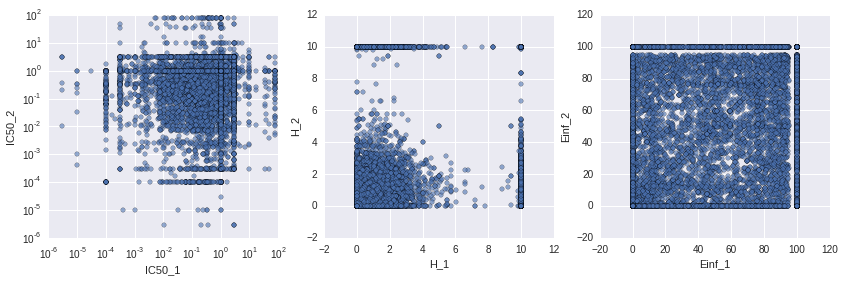

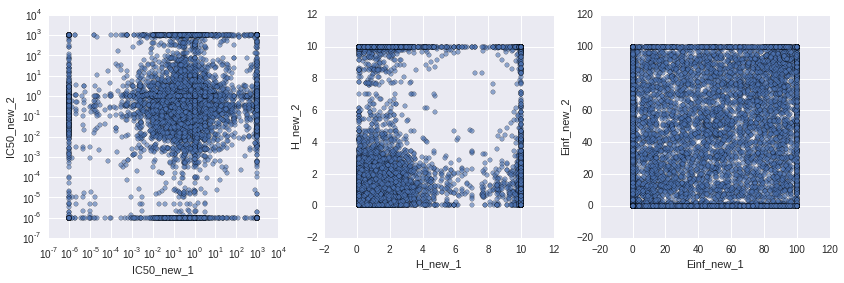

In [174]:
# Plot correlation between monotherapy features (SAME CELL_LINE AND MAX_CONC!)
def plot_correlations(df_input):
    df1a = (
        df_input
        [(df_input['QA'] == 1)]
        [['CELL_LINE', 'AGENT_A', 'IC50_A', 'H_A', 'Einf_A', 'IC50_A_new', 'H_A_new', 'Einf_A_new']]
        .dropna()
        .rename(columns=lambda x: x.replace('_A', ''))
    )

    df1b = (
        df_input
        [(df_input['QA'] == 1)]
        [['CELL_LINE', 'AGENT_B', 'IC50_B', 'H_B', 'Einf_B', 'IC50_B_new', 'H_B_new', 'Einf_B_new']]
        .dropna()
        .rename(columns=lambda x: x.replace('_B', ''))
    )

    df1 = pd.concat([df1a, df1b], ignore_index=True).reset_index()
    display(HTML('<b>df1</b>'))
    display(df1.head())

    df = df1.merge(df1.copy(), on=['CELL_LINE', 'AGENT'], how='outer', suffixes=('_1', '_2'))
    df = df[df['index_1'] != df['index_2']]

    #
    display(HTML('<b>df</b>'))
    display(df[['IC50_1', 'H_1', 'Einf_1', 'IC50_2', 'H_2', 'Einf_2']].corr())

    fg, ax = plt.subplots(1,3,figsize=(14,4))
    df.plot(x='IC50_1', y='IC50_2', kind='scatter', alpha=0.6, loglog=True, ax=ax[0])
    df.plot(x='H_1', y='H_2', kind='scatter', alpha=0.6, ax=ax[1])
    df.plot(x='Einf_1', y='Einf_2', kind='scatter', alpha=0.6, ax=ax[2])

    #
    display(HTML('<b>df</b>'))
    display(df[['IC50_new_1', 'H_new_1', 'Einf_new_1', 'IC50_new_2', 'H_new_2', 'Einf_new_2']].corr())
    
    fg, ax = plt.subplots(1,3,figsize=(14,4))
    df.plot(x='IC50_new_1', y='IC50_new_2', kind='scatter', alpha=0.6, loglog=True, ax=ax[0])
    df.plot(x='H_new_1', y='H_new_2', kind='scatter', alpha=0.6, ax=ax[1])
    df.plot(x='Einf_new_1', y='Einf_new_2', kind='scatter', alpha=0.6, ax=ax[2])
    
plot_correlations(df)

In [175]:



9

9

In [ ]:
np.log10(0.1)

In [ ]:
p = df.loc[0, ['IC50_A_new', 'H_A_new', 'Einf_A_new']]
p[0] = np.log10(p[0])
x = df.loc[0, 'MONOTHERAPY_A_X']
y = df.loc[0, 'MONOTHERAPY_A_Y']

y_pred = hill_log(p, x)

plt.plot(x, y_pred)
plt.plot(x, y, 'ro')

In [ ]:
error_fn(
    df.loc[0, ['IC50_A_new', 'H_A_new', 'Einf_A_new']],
    df.loc[0, 'MONOTHERAPY_A_X'],
    df.loc[0, 'MONOTHERAPY_A_Y']
)

In [ ]:
df.loc[0, 'MONOTHERAPY_A_X']

In [ ]:
sns.regplot(x='IC50_B', y='IC50_B_new', data=df)

In [ ]:
df[[c for c in df.columns if c.startswith(('IC50_', 'H_', 'Einf_'))]].corr()

In [ ]:
%matplotlib inline

In [ ]:
'asdf'.startswith(('a', 'b'))

In [ ]:
list(zip(*
    df[['IC50_B', 'H_B', 'Einf_B', 'MONOTHERAPY_A_X', 'MONOTHERAPY_A_Y']]
    .apply(fit_hill, axis=1).values
))

In [ ]:
df.head()

In [ ]:
new_df.shape

In [ ]:
ch1_train_combination_and_monotherapy.shape

In [ ]:
ch1_train_combination_and_monotherapy.drop_duplicates(['CELL_LINE', 'COMBINATION_ID']).shape

In [ ]:
set(ch1_train_combination_and_monotherapy['UNIT_B'])

In [ ]:
ch1_train_combination_and_monotherapy[['AGENT_A', ]

In [ ]:
ch1_train_combination_and_monotherapy.head()

In [ ]:
def populate_compound_params(compound_params, df):
    column_sets = [
        ['CELL_LINE', 'COMPOUND_A', 'IC50_A', 'H_A', 'Einf_A'],
        ['CELL_LINE', 'COMPOUND_B', 'IC50_B', 'H_B', 'Einf_B'],
    ]
    for columns in column_sets:
        for cell_line, compound, ic50, h, e_inf in df[columns].values:
            compound_params.setdefault((cell_line, compound), []).append((ic50, h, e_inf))

compound_params = dict()
populate_compound_params(compound_params, ch1_train_combination_and_monotherapy)
populate_compound_params(compound_params, ch1_leaderboard_monotherapy)
populate_compound_params(compound_params, ch1_test_monotherapy)
populate_compound_params(compound_params, ch2_leaderboard_monotherapy)
populate_compound_params(compound_params, ch2_test_monotherapy)

compound_params_means = dict()
for key, values in compound_params.items():
    means = list(map(np.mean, zip(*values)))
    compound_params_means[key] = means

In [ ]:
'{ccc}'.format(ccc=100)

In [ ]:
ch1_train_combination_and_monotherapy.head()

In [ ]:
combinations[combinations['REP'] == 'Rep2']

In [ ]:
combinations = pd.DataFrame(
    data=os.listdir(op.join(PATH_TO_RAW_DATA, 'ch1_training_combinations')),
    columns=['FILENAME']
)
combinations['COMPOUND_A'], combinations['COMPOUND_B'], combinations['CELL_LINE'], combinations['REP'], __ = \
    zip(*combinations['FILENAME'].apply(lambda x: x.split('.')))
combinations['DATA'] = combinations['FILENAME'].apply(
    lambda x: pd.read_csv(op.join(PATH_TO_RAW_DATA, 'ch1_training_combinations', x), sep=',', index_col=0))
display(combinations.head())

In [ ]:
combinations['MONOTHERAPY_A_X'] = combinations['DATA'].apply(lambda x: x.index[:6].values)
combinations['MONOTHERAPY_A_Y'] = combinations['DATA'].apply(lambda x: x['0'][:6].values)
combinations['MONOTHERAPY_B_X'] = combinations['DATA'].apply(lambda x: x.columns[:6].values)
combinations['MONOTHERAPY_B_Y'] = combinations['DATA'].apply(lambda x: x.loc['0'][:6].values)

In [ ]:
monotherapies = pd.DataFrame(
    data=os.listdir(op.join(PATH_TO_RAW_DATA, 'ch1_ch2_monoTherapy')),
    columns=['FILENAME']
)
monotherapies['COMPOUND_A'], monotherapies['COMPOUND_B'], monotherapies['CELL_LINE'], monotherapies['REP'], __ = \
    zip(*monotherapies['FILENAME'].apply(lambda x: x.split('.')))
monotherapies['DATA'] = monotherapies['FILENAME'].apply(
    lambda x: pd.read_csv(op.join(PATH_TO_RAW_DATA, 'ch1_ch2_monoTherapy', x), sep=',', index_col=0))
display(monotherapies.head())

In [ ]:
monotherapies['MONOTHERAPY_A_X'] = monotherapies['DATA'].apply(lambda x: x.index[:6].values)
monotherapies['MONOTHERAPY_A_Y'] = monotherapies['DATA'].apply(lambda x: x['0'][:6].values)
monotherapies['MONOTHERAPY_B_X'] = monotherapies['DATA'].apply(lambda x: x.columns[:6].values)
monotherapies['MONOTHERAPY_B_Y'] = monotherapies['DATA'].apply(lambda x: x.loc['0'][:6].values)

In [ ]:
!ls  | head

In [ ]:
df = (
    ch1_train_combination_and_monotherapy
    .groupby(['COMPOUND_A', 'COMPOUND_B'])
    .agg(lambda x: tuple(x))
)

In [ ]:
df = pd.read_csv(
    'challenge_data/drug_synergy_data/raw_data/Raw_Data_csv/ch1_training_combinations/'
    'ADAM17.AKT.BT-20.Rep1.csv',
    sep=',', index_col=0,
)
df

In [ ]:
ch1_train_combination_and_monotherapy[
    (ch1_train_combination_and_monotherapy['COMPOUND_A'] == 'ADAM17') &
    (ch1_train_combination_and_monotherapy['COMPOUND_B'] == 'AKT') & 
    (ch1_train_combination_and_monotherapy['CELL_LINE'] == 'BT-20')
]

In [ ]:
def foo(x, y):
    def bar(p):
        return '{} {} {}'.format(x, y, p)
    return bar

print(foo(10,20)(30))
print(foo(20,20)(30))
print(foo(10,'xxx')(30))
print(foo('yyy',20)(30))

In [ ]:
def populate_compound_params(compound_params, df):
    column_sets = [
        ['CELL_LINE', 'COMPOUND_A', 'IC50_A', 'H_A', 'Einf_A'],
        ['CELL_LINE', 'COMPOUND_B', 'IC50_B', 'H_B', 'Einf_B'],
    ]
    for columns in column_sets:
        for cell_line, compound, ic50, h, e_inf in df[columns].values:
            compound_params.setdefault((cell_line, compound), []).append((ic50, h, e_inf))

compound_params = dict()
populate_compound_params(compound_params, ch1_train_combination_and_monotherapy)
populate_compound_params(compound_params, ch1_leaderboard_monotherapy)
populate_compound_params(compound_params, ch1_test_monotherapy)
populate_compound_params(compound_params, ch2_leaderboard_monotherapy)
populate_compound_params(compound_params, ch2_test_monotherapy)

compound_params_means = dict()
for key, values in compound_params.items():
    means = list(map(np.mean, zip(*values)))
    compound_params_means[key] = means

In [ ]:
combinations.head()

In [ ]:
plsq = fit_hill(['DU-4475', 'PIK3CB_PIK3CD', [0, 0.01, 0.03, 0.1, 0.3, 1], [100, 85.6, 20.7, 4.9, 3.1, 0.4]])

In [ ]:
plsq

In [ ]:
error_fn(np.array([1., 1., 0.]), np.array([0, 0.01, 0.03, 0.1, 0.3, 1]), np.array([100, 85.6, 20.7, 4.9, 3.1, 0.4]))

In [ ]:
x = np.array([0, 0.01, 0.03, 0.1, 0.3, 1])
y = np.array([100, 85.6, 20.7, 4.9, 3.1, 0.4])
p0 = np.array([_get_p0_ec50(x, y), 1., 0.])
p0 = np.array([0.001, 1., 0.])
p0_bounds = [(-1,100), (0, 1000), (0,100)]

plsq = sp.optimize.minimize(error_fn, p0, args=(x, y), method='L-BFGS-B', bounds=p0_bounds)
print(plsq)
plt.plot(x, hill(x, plsq.x))
plt.plot(x, y, 'r.')

In [ ]:
%matplotlib inline

In [ ]:
(
    zip(*combinations[['CELL_LINE', 'COMPOUND_A', 'MONOTHERAPY_A_X', 'MONOTHERAPY_A_Y']][:10]
        .apply(fit_hill, axis=1, raw=True))
)

In [ ]:
list(zip(*
    combinations[['CELL_LINE', 'COMPOUND_A', 'MONOTHERAPY_A_X', 'MONOTHERAPY_A_Y']][:10]
    .apply(fit_hill, axis=1).values
))

In [ ]:
x = _

In [ ]:
x.

In [ ]:
##
p0 = [1, 0.809, 59.122]
p0_bounds = [(0,100), (0,10), (0,100)]

x = [0, 0.01, 0.03, 0.1, 0.3, 1]
y = [100, 96.5, 97.6, 95.6, 88.8, 79.4]

plsq = sp.optimize.minimize(error_fn, p0, args=(x,y), method='L-BFGS-B', bounds=p0_bounds)
print(plsq)

In [ ]:
p0

In [ ]:
list(plsq.x) + [plsq.fun]

In [ ]:
plt.plot(x, hill(x, plsq.x), 'b-')
plt.plot(x, hill(x, np.array(p0)), 'k-')
plt.plot(x, y, 'ro')

In [ ]:
def get_fn(x, y):
    def fn(p):
        score = 0
        for i in range(len(x)):
            score += (y[i] - hill(x[i], p))**2
        score = np.sqrt(score)
        return score
    return fn

def constraints_fn(p):
    ic_50, h, e_inf = p
    satisfied = (
        (ic_50 >= 0 and ic_50 <= 100000) and
        (h >= 0 and h <= 50) and
        (e_inf >= 0 and i_einf <= 100)
    )
    return satisfied
constraints = dict(
    type='eq',
    fun=constraints_fn,
)

def residuals(p, y, x):
    ic_50, h, e_inf = p
    err = (
        list(y - hill(x, ic_50, h, e_inf))
        + [w * tub(ic_50, 0, 10000), w * tub(h, 1, 1), w * tub(e_inf, 0, 100)]
    )
    return err

 = sp.optimize.leastsq(residuals, p0, args=(y0, x0), maxfev=5000)



In [ ]:
plt.plot(x0, hill(x0, *plsq[0]))
plt.plot(x0, y0, 'r.')